# Big project activity

## Optimal chargin station location

### 1.Introduction

Consider a long linear cycle path  as Vento, or the Danube cycle path. The cycle path usually runs along the banks of a river with scarse tourist interest. However, from the main course of the cycle path it is possible to reach places of tourist interest by making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. Moreover, the presence of a charging station could also induce e-cyclists to discover new places and generate positive externalities.



### 2.Decision problem
We can represent the cycle path as a graph where the set of nodes $H = \{1,\ldots,n\}$ corresponds to the tourist sites that may host a charging station.
In addition we are given the distances between touristic site ($d_{ij},$ with $ i,j =1,\ldots,n$). Let $c_i$ be the cost of installing a charging station in site $i, i=1\ldots,n$.


The problem is, given a budget $b$, determine the subset of sites $S\subseteq H$ where to install the charging stations so that the total cost is not higher than $b$ and the maximum distance between consecutive charging stations is minimized.
Consider that the cyclist has to visit all the touristic destination in a consecutive way.



### 3.Problem characteristics
There are 2 csv files that contain the information of the cycle way, they are essential to build the equivalent graph:


*    in the "nodes.csv" file there are all the destinations that the cyclist can reach, with their spatial coordinates and the value of installation costs related to that destination. Consider that the "tourist-dest-id" is not the graph node number but it is an unique id to identify the destination.
*   in the "OD.csv" you can find all the arcs between two different nodes, keep attention that the condition of visiting consecutive touristic destination must be respected.

The set of nodes $N$ is defined by $\{0,1,\ldots,n, n+1\}$.  The Arcs $A$ correspond to the portion of cycle path between two consecutive charging stations. We assume that potentially e-riders will visit all sites along the way making the suitable deviations and going back to the main path at the initial point of the detour.
The cost associated with each  arc $(i,j)$ is given by $c_j$, thus the cost of installing a charging station in $j$. These costs are defined for all arcs in $A$, while they are set to 0 for all the arcs that arrive in the last node.
The path starts in node $s = 0$ and ends in node $t = n+1$, these two nodes are connected to the nearest touristic site with an arc of null length.

### 4.Example of linear path with deviation
![picture](https://drive.google.com/uc?export=view&id=1w16bHtbu0FGGL-UntxeqxD7244D3eHbJ)

### 5.Requirements
The requirements of the problem are:

*   the distance between two active consecutive station must be less than 50 km
*   the maximum running time of the algorithm must be 5 minutes, so set the proper timer
*   create the equivalent graph and display it on a xy-plot
*   find the solution for the basic scenario, with a mip model, displaying the solution with a xy-plot, the budget constrain is $b = 10000\ € $.
*   Find the optimal solution for 5 different values of budget in the range $[10000, 100000]$. Select the values of the budget so as to have different charger locations.

  You have to motivate you choice and the solution you get. They can also be not common solution if they are well motivated. To support your decision and explanations you can print plots or tables. You can also compare different scenarios.


   
If you have some doubts related to the parametric analysis prof. Cubillos uploaded a notebook with the solution on WeBeeP and you can have a look there.

### Insert student name and student ID

student1: Niccolò Betto


student2: Caterina Clapci


student3: Giorgio Algisi


In [ ]:
# Install and import libraries

requirements = {
    "pandas": "2.2.0",
    "numpy": "1.26.3",
    "mip": "1.15.0",
    "matplotlib": "3.8.2",
    "networkx": "3.2.1",
    "chardet": "5.2.0",
}

#!pip install cffi==1.15.0

# Try to import libraries and install them if not found
for i in range(2):
    try:
        import pandas as pd
        import numpy as np
        import mip
        import networkx as nx
        import matplotlib.pyplot as plt
        import math
        import chardet
    except ImportError:
        print("Installing required libraries...")
        for package, version in requirements.items():
            !pip install {package}=={version}
        continue
    break

In [2]:
# Read the CSV input files

# Controls whether charset detection is used when reading the CSV files
ENABLE_CHARSET_DETECTION = True

from pathlib import Path
import io

NODE_FILE = Path("nodes.csv")
ARC_FILE = Path("OD.csv")


# Motivation: The CSV files may be encoded in different charsets, such as UTF-8, ISO-8859-1, Windows-1252, etc.
# We need to detect the charset to read the files correctly
def read_bytes(path):
    """Read the file to memory and detect the encoding"""

    bin = path.read_bytes()
    encoding = "utf-8"

    if ENABLE_CHARSET_DETECTION:
        detected = chardet.detect(bin)
        encoding = detected.get("encoding", encoding)
        print(f"Detected encoding '{encoding}' for '{path}'")

    return io.BytesIO(bin), encoding


node_bytes, node_encoding = read_bytes(NODE_FILE)

node_columns = {
    "tourist_dest_id": "int",
    "x (longitude)": "float",
    "y (latitude)": "float",
    "Cost_of_installation [€]": "float",
}
node_dataframe = pd.read_csv(
    node_bytes,
    encoding=node_encoding,
    usecols=list(node_columns.keys()),
    dtype=node_columns,
)

arc_bytes, arc_encoding = read_bytes(ARC_FILE)

arc_columns = {"origin_id": "int", "destination_id": "int64", "distance [m]": "float"}
arc_dataframe = pd.read_csv(
    arc_bytes,
    encoding=arc_encoding,
    usecols=list(arc_columns.keys()),
    dtype=arc_columns,
)

Detected encoding 'Windows-1252' for 'nodes.csv'
Detected encoding 'ascii' for 'OD.csv'


In [3]:
# Setup the execution timer

ENABLE_TIMER = True
TIME_LIMIT = 5 * 60  # seconds

import sys
import signal


def start_timer(time):
    """Arms the execution timer to terminate the program after the given time."""

    def alarm_handler(signum, frame):
        sys.exit(
            f"Time limit of {time} seconds exceeded, the program has been terminated."
        )

    signal.signal(signal.SIGALRM, alarm_handler)
    signal.alarm(time)


def stop_timer():
    """Disarms the execution timer."""
    signal.alarm(0)


if ENABLE_TIMER:
    start_timer(TIME_LIMIT)

In [4]:
# Graph utility methods


def detect_cycle(set_of_arcs, arc):
    """Detects circular paths in the graph."""

    for i in set_of_arcs:
        if i == arc[1] and set_of_arcs[i] == arc[0]:
            return True
    return False


def compute_distance(nodeA, nodeB):
    """Computes the Euclidean distance between two points."""

    return math.sqrt(((nodeB[0] - nodeA[0]) ** 2) + ((nodeB[1] - nodeA[1]) ** 2))


def create_path(first_node, set_of_all_arcs, set_of_nodes):
    """
    Create the cycle path based on the coordinates x,y of point
    set_of_all_arcs = [[id1,id2,distance]], set_of_nodes = { (id): [coord_x, coord_y] }
    return path = { node: following_node}
    """

    path = {}
    set_of_remaining_nodes = list(set_of_nodes)
    next_node = first_node

    while len(set_of_remaining_nodes) != 1:
        # Get all the outgoing arcs of considered node (next node)
        outgoing_arcs = [
            [i[0], i[1], compute_distance(set_of_nodes[i[0]], set_of_nodes[i[1]])]
            for i in set_of_all_arcs
            if i[0] == next_node
        ]
        # Remove the node from the set of remaining nodes
        set_of_remaining_nodes.remove(next_node)
        # Compute the nearest node among the remaining nodes
        nearest_node = [-1, -1, -1]
        for i in outgoing_arcs:
            if nearest_node[0] == -1 or nearest_node[2] == 0:
                nearest_node = i
            elif (
                nearest_node[2] > i[2]
                and not detect_cycle(path, i)
                and i[1] in set_of_remaining_nodes
            ):
                nearest_node = i

        path.update({nearest_node[0]: nearest_node[1]})
        next_node = nearest_node[1]

    return [path, set_of_remaining_nodes[0]]

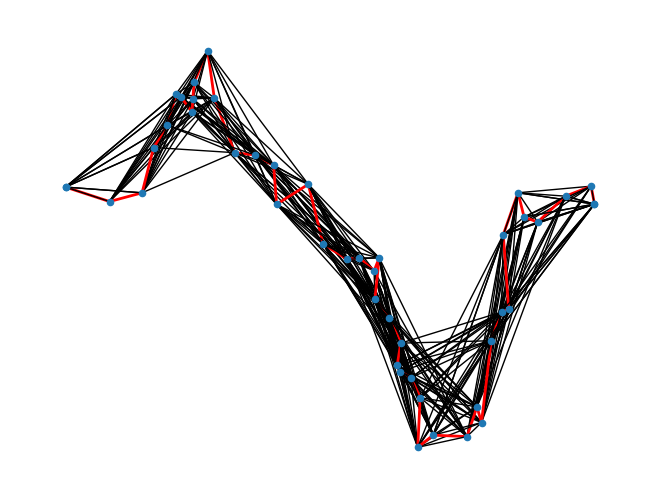

In [5]:
# Define the problem's parameters, the cycle path and the equivalent graph

# Distance threshold
MAX_DISTANCE = 50000.0  # 50 km

H_attributes = node_dataframe.to_numpy(na_value=0.0, dtype=object)

# H(i) = set of nodes of the cycle path
H: dict[int, tuple[float, float]] = {i[0]: (i[1], i[2]) for i in H_attributes}

# c(i) = installation cost of each charging station
c: dict[int, float] = {i[0]: i[3] for i in H_attributes}

# Read empty CSV cells as 0.0
distances = arc_dataframe.to_numpy(na_value=0.0, dtype=object)

# d(i,j) = distances between nodes (1 to n) of the cycle path
d: dict[tuple[int, int], float] = {(i[0], i[1]): i[2] for i in distances}

# Find the first node on the cycle path, the one with the lowest longitude
first_node = -1
for i in H:
    if first_node < 0:
        first_node = i
    if H[i][0] < H[first_node][0]:
        first_node = i

# Create the cycle path graph
cycle_path, last_node = create_path(first_node, distances, H)
cycle_path_arcs = [(i, cycle_path[i]) for i in cycle_path]

# Add the initial (s) and final (t) nodes with placeholder IDs and zero cost
s = -1
t = -2
cycle_path.update({s: first_node, last_node: t})
d.update({(s, first_node): 0, (last_node, t): 0})
H.update({s: H[first_node], t: H[last_node]})
c.update({s: 0})
c.update({t: 0})

# N is the set of all nodes
N = H
# A is the set of arcs between following node (through the path) that have a distances in between less than 50 km
A = []
# equal_distance contains the distance between two nodes (i,j) if the distance is less than 50 km
equal_distance = {}

# Create the equivalent graph (the graph with all arcs with a distance less than 50 km)
for i in N:
    if i != t:
        node_from = i
        max_distance = 0
        stop = 0
        while node_from != t and not stop:
            node_to = cycle_path[node_from]
            max_distance = max_distance + d[node_from, node_to]
            if max_distance <= MAX_DISTANCE:
                A.append((i, node_to))
                equal_distance.update({(i, node_to): max_distance})
            else:
                stop = 1
            node_from = node_to

# Draw the equivalent graph (black) and the cycle path (red)
g = nx.Graph()
g.add_nodes_from(N)
g.add_edges_from(A, color="k", width=1)
g.add_edges_from(cycle_path_arcs, color="r", width=2)

edge_color = nx.get_edge_attributes(g, "color").values()
edge_width = nx.get_edge_attributes(g, "width").values()
nx.draw(g, pos=N, node_size=20, edge_color=edge_color, width=list(edge_width))

In [6]:
# Create the optimization model


def solve_cycle_problem(N, A, MAX_BUDGET):
    """
    Compure the optimal solution for the cycle problem for a given budget.

    N = set of nodes, A = set of arcs, MAX_BUDGET = maximum budget
    Returns the active nodes, active arcs, the maximum distance and the total cost of the active nodes
    """

    m = mip.Model()
    # Suppress the output of the optimization
    m.verbose = 0

    # Variable x indicates whether the charging station at node i is active or not
    x = {i: m.add_var(var_type=mip.BINARY) for i in N}
    # Variable y indicates whether the arc (i, j) is active or not, for each arc in A (arcs < 50 km)
    y = {(i, j): m.add_var(var_type=mip.BINARY) for (i, j) in A}
    # The distance between two active charging stations
    max_distance = m.add_var(var_type=mip.CONTINUOUS)

    # Variable b specifies the number of arcs for each node,
    # computed as the difference between the number of ingoing and outgoing arcs
    #   <n. of ingoing arcs> - <n. of outgoing arcs>
    # e.g. The starting node S has only one outgoing arc:
    #   ingoing(S) - outgoing(S) = 0 - 1 = -1
    b = {i: -1 if i == s else 1 if i == t else 0 for i in N}

    # Constraint: the start and end nodes are always active
    m.add_constr(x[s] == 1)
    m.add_constr(x[t] == 1)

    # Constraint: every node only has one ingoing arc and one outgoing arc (see the two constraints below)
    for i in N:
        # Constraint 1: the number of ingoing arcs minus the number of outgoing arcs is equal to b[i]
        m.add_constr(
            (
                mip.xsum(y[j, i] for j in N if (j, i) in A)  # ingoing arcs
                - mip.xsum(y[i, j] for j in N if (i, j) in A)  # outgoing arcs
            )
            == b[i]
        )
        # Constraint 2: a node can be reached by at most one arc
        m.add_constr(mip.xsum(y[j, i] for j in N if (j, i) in A) <= 1)  # type: ignore

    # Constraint: the active nodes' cost must be below the maximum budget
    m.add_constr(mip.xsum(y[i, j] * c[j] for (i, j) in A) <= MAX_BUDGET)  # type: ignore

    # Constraint: every active node is a node reached by one arc (and consequently with an outgooing arc)
    for i in N:
        if i != s and i != t:
            m.add_constr(x[i] == mip.xsum(y[j, i] for j in N if (j, i) in A))

    # Constraint: this is a linear bottleneck assignment problem where we have to minimize the maximum distance
    # We trasformed the non linear function min(max(distance)) into a linear function min(max_distance) and
    # introduce the following constraint to define the maximum distance
    for i, j in A:
        m.add_constr(max_distance >= y[i, j] * equal_distance[i, j])

    # Objective function: minimize the maximum distance
    m.objective = mip.minimize(max_distance)

    # Run the optimization
    m.optimize()

    # Return the nodes and arcs that are active after the optimization
    N_sol = {i: (N[i][0], N[i][1]) for i in x if x[i].x == 1}
    A_sol = {(i, j) for (i, j) in A if y[i, j].x == 1}
    obj_val = m.objective_value
    cost = sum(c[i] for i in N_sol)

    return N_sol, A_sol, obj_val, cost

BUDGET: €10000 - OBJ VALUE: 38228.51958 - COST €9506.0 - ACTIVE STATIONS: 8


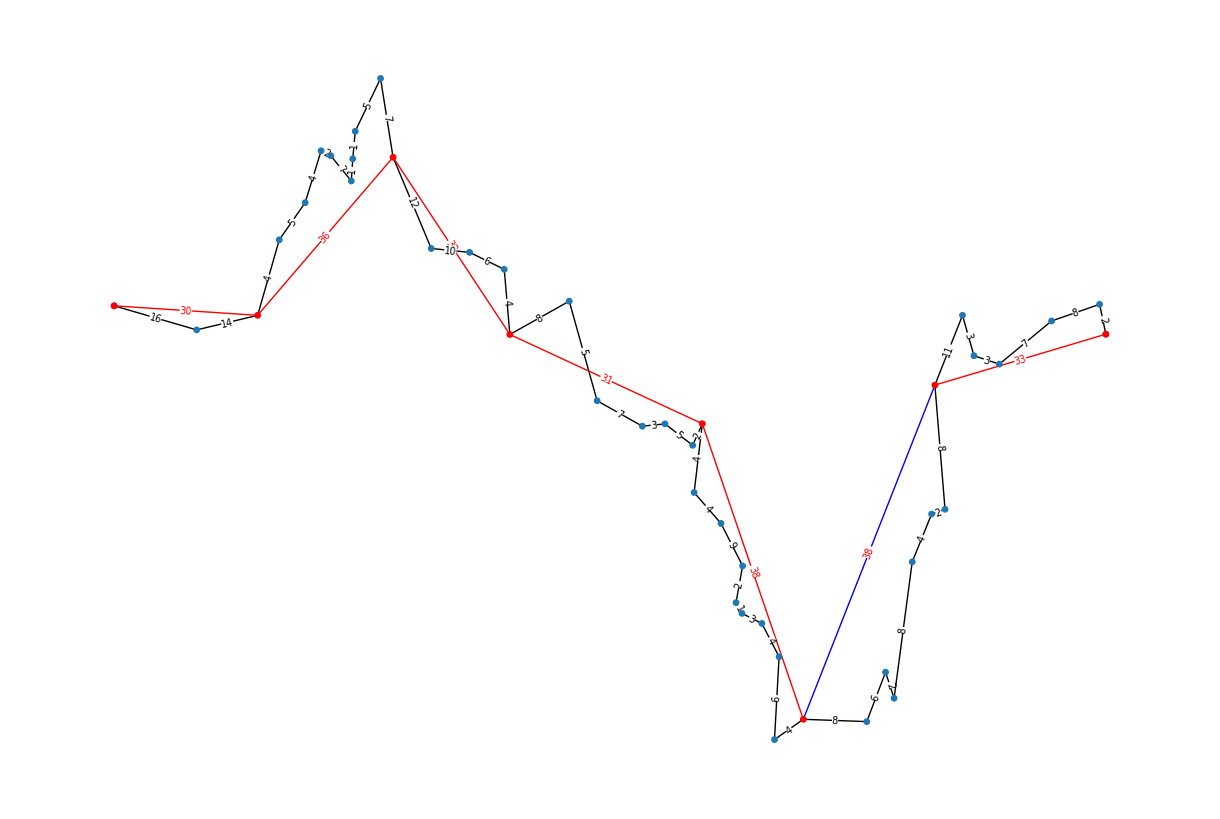

In [7]:
# Basic scenario optimization: MAX_BUDGET 10000

MAX_BUDGET = 10000

# Compute the optimal solution for the basic scenario
N_sol, A_sol, obj_val, cost = solve_cycle_problem(N, A, MAX_BUDGET)

if obj_val is None:
    print(f"No feasible solution found for budget: €{MAX_BUDGET}")
else:
    print(
        f"BUDGET: €{MAX_BUDGET} - OBJ VALUE: {obj_val} - COST €{cost} - ACTIVE STATIONS: {len(N_sol)}"
    )

g = nx.Graph()
g.add_nodes_from(N)
# Draw the cycle graph as black
g.add_edges_from(cycle_path_arcs, color="k")
# Draw the active arcs as red
g.add_edges_from(A_sol, color="r")

# Draw the max edge as blue
try:
    max_edge = max(A_sol, key=lambda e: equal_distance[e])
    g.add_edge(*max_edge, color="b")
except ValueError:
    pass

# Draw the active nodes as red
node_color = ["red" if node in N_sol else "#1f78b4" for node in N]
edge_color = nx.get_edge_attributes(g, "color").values()

edge_labels_sol = {(i, j): f"{equal_distance[i, j] / 1000:.0f}" for (i, j) in A_sol}
edge_labels_path = {
    (i, j): f"{equal_distance[i, j] / 1000:.0f}" for (i, j) in cycle_path_arcs
}

plt.figure(1, figsize=(12, 8), dpi=100)
nx.draw(g, pos=N, node_size=15, node_color=node_color, edge_color=edge_color)

# Arc label parameters
label_bbox = {
    "boxstyle": "round",
    "ec": (1.0, 1.0, 1.0),
    "fc": (1.0, 1.0, 1.0),
    "pad": 0,
    "lw": 0,
}
# Draw distance labels on the arcs
nx.draw_networkx_edge_labels(
    g,
    pos=N,
    edge_labels=edge_labels_sol,
    font_color="red",
    font_size=7,
    bbox=label_bbox,
)
nx.draw_networkx_edge_labels(
    g,
    pos=N,
    edge_labels=edge_labels_path,
    font_color="black",
    font_size=7,
    bbox=label_bbox,
);

### Graph comment

The labels shown on the arcs are meant as approximations of the real values, since the full values would overlap and make the graph unreadable.  


BUDGET: €15000 - OBJ VALUE: 28056.972876000003 - ACTIVE STATIONS: 11 - COST €14964.0 - COLOR: red
BUDGET: €28000 - OBJ VALUE: 16911.602982 - ACTIVE STATIONS: 18 - COST €26665.0 - COLOR: green
BUDGET: €29000 - OBJ VALUE: 16011.18979 - ACTIVE STATIONS: 19 - COST €28507.0 - COLOR: blue
BUDGET: €35000 - OBJ VALUE: 16011.18979 - ACTIVE STATIONS: 22 - COST €34368.0 - COLOR: pink
BUDGET: €100000 - OBJ VALUE: 16011.18979 - ACTIVE STATIONS: 23 - COST €35655.0 - COLOR: orange


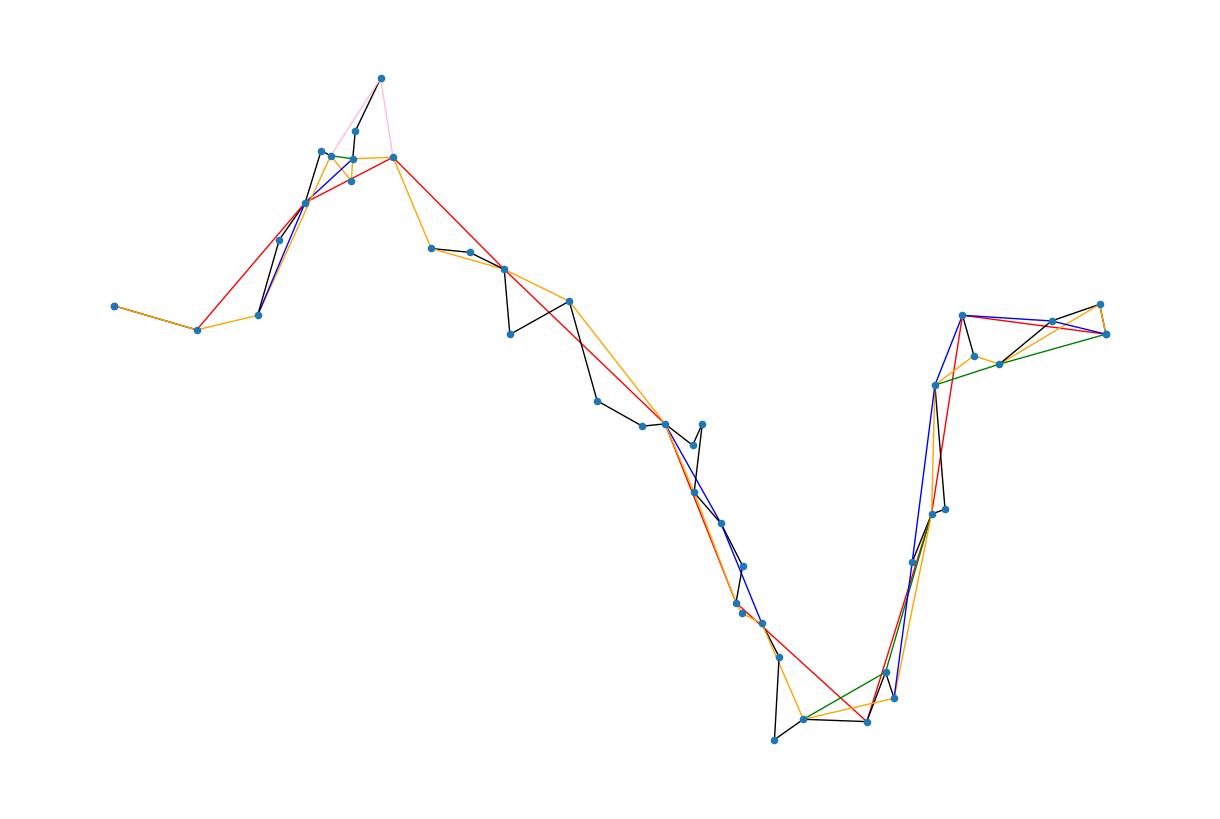

In [8]:
# Parametric analysis

# Define the budgets and the corresponding colors
budgets = {15000: "red", 28000: "green", 29000: "blue", 35000: "pink", 100000: "orange"}

g = nx.Graph()
g.add_nodes_from(N)
# Draw the cycle path in black
g.add_edges_from(cycle_path_arcs, color="k")

# Compute the solution for each budget and draw the graph
for budget, color in budgets.items():
    N_sol, A_sol, obj_val, cost = solve_cycle_problem(N, A, budget)

    if obj_val is None:
        print(f"No feasible solution found for budget: €{budget}")
    else:
        print(
            f"BUDGET: €{budget} - OBJ VALUE: {obj_val} - ACTIVE STATIONS: {len(N_sol)} - COST €{cost} - COLOR: {color}"
        )

    g.add_edges_from(A_sol, color=color)

edge_color = nx.get_edge_attributes(g, "color").values()
plt.figure(2, figsize=(12, 8), dpi=100)
nx.draw(g, pos=N, node_size=20, edge_color=edge_color)

## Parametric Analysis Comment

With low budget values, fewer stations are active, threfore the distance between them is high.  
For example, when the budget was €15000, only 11 stations were activated, and the maximum distance between active stations was ~28km.  

As we gradually increase the budget, more and more stations are being activated, so the maximum distance between active stations decreases.  
For instance, with a budget of €28000, we can see that 18 stations were activated, 7 more than the previous case, and the maximum distance between active stations decreased by ~11km, to ~17km.

Finally, once the budget of €28102 is reached, the solution reaches a plateau, and the maximum distance between active stations remains stable as the budget increases, up to €100000.  
In particular, when the budget goes over €28102 enough stations are activated such that the maximum distance is found between two consecutive stations on the cycle path.  
At this point there is no station that can be activated to reduce the maximum distance, so further budget increases do not yield a reduction of the objective value.

BUDGET: €28101 - OBJ VALUE: 16911.602982 - ACTIVE STATIONS: 18 - COST €26665.0 - COLOR: blue
BUDGET: €28102 - OBJ VALUE: 16011.18979 - ACTIVE STATIONS: 19 - COST €28102.0 - COLOR: red
BUDGET: €28103 - OBJ VALUE: 16011.18979 - ACTIVE STATIONS: 19 - COST €28102.0 - COLOR: None


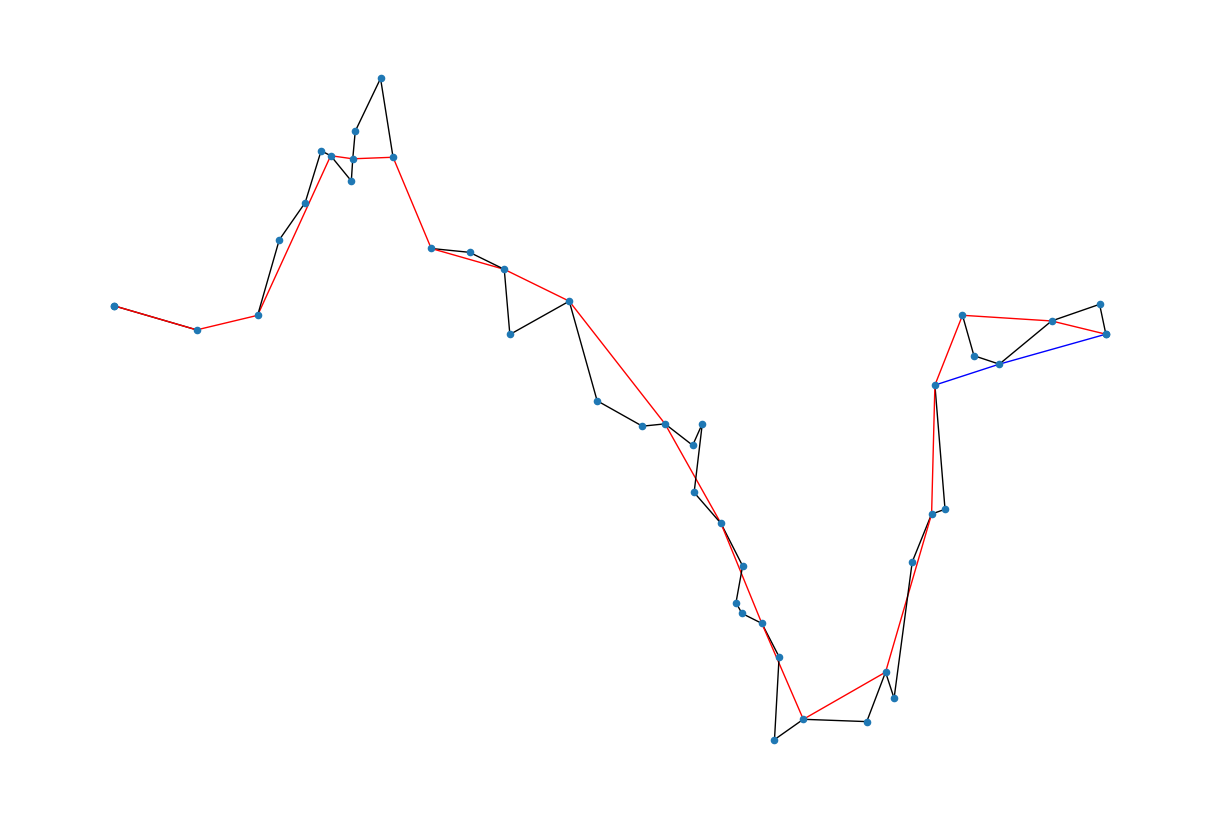

In [9]:
# Parametric analysis: focus on the plateau point

# Define the budgets and the corresponding colors
# We skip drawing the graph for budget 28103 as it would overlap with the 28102 graph
budgets = {28101: "blue", 28102: "red", 28103: None}

g = nx.Graph()
g.add_nodes_from(N)
# Draw the cycle path in black
g.add_edges_from(cycle_path_arcs, color="k")

# Compute the solution for each budget and draw the graph
for budget, color in budgets.items():
    N_sol, A_sol, obj_val, cost = solve_cycle_problem(N, A, budget)

    if obj_val is None:
        print(f"No feasible solution found for budget: €{budget}")
    else:
        print(
            f"BUDGET: €{budget} - OBJ VALUE: {obj_val} - ACTIVE STATIONS: {len(N_sol)} - COST €{cost} - COLOR: {color}"
        )

    if color:
        g.add_edges_from(A_sol, color=color)

edge_color = nx.get_edge_attributes(g, "color").values()
plt.figure(3, figsize=(12, 8), dpi=100)
nx.draw(g, pos=N, node_size=20, edge_color=edge_color)


In [10]:
# Stop the timer
stop_timer()